In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import ast
from analyze_masks import analyze_masks_and_list_exceptions

def categorize_data(data, column):
    """ Categorize the data based on quantiles for a specific column """
    q33 = data[column].quantile(0.33)
    q66 = data[column].quantile(0.66)
    
    category_labels = ["small", "medium", "large"]
    
    conditions = [
        (data[column] <= q33),
        (data[column] > q33) & (data[column] <= q66),
        (data[column] > q66)
    ]
    
    data[f'{column}_category'] = np.select(conditions, category_labels)
    return data

In [3]:
def load_and_process_data(file_path, base_dir, masks_dir):
    data = pd.read_csv(file_path)
    confidence_columns = [col for col in data.columns if 'confidence' in col]
    for column in confidence_columns:
        data[column] = data[column].apply(ast.literal_eval)

    data['width'] = 0
    data['height'] = 0
    data['object_percentage'] = 0.0

    class_to_grayscale_map = analyze_masks_and_list_exceptions(masks_dir)

    for index, row in data.iterrows():
        class_id = row['id'].split('_')[0]
        picture_name = row['picture_name']
        picture_base_name = os.path.splitext(picture_name)[0]

        img_path = os.path.join(base_dir, 'train', class_id, picture_name)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                data.at[index, 'width'] = width
                data.at[index, 'height'] = height
        except FileNotFoundError:
            print(f"Image not found: {img_path}")

        mask_name = picture_base_name + '.png'
        mask_path = os.path.join(masks_dir, class_id, mask_name)
        try:
            with Image.open(mask_path) as mask:
                mask_array = np.array(mask)
                if class_id in class_to_grayscale_map:
                    relevant_value = class_to_grayscale_map[class_id]
                    object_pixels = np.sum(mask_array == relevant_value)
                    total_pixels = width * height
                    data.at[index, 'object_percentage'] = (object_pixels / total_pixels) * 100
        except FileNotFoundError:
            print(f"Mask not found for image: {mask_path}")

    data = categorize_data(data, 'object_percentage')

    return data

In [4]:
def parse_synset_mapping(filepath):
    with open(filepath, 'r') as file:
        class_dict = {}
        for row_number, line in enumerate(file, start=1):
            class_id, description = line.strip().split(' ', 1)
            class_dict[class_id] = {
                "description": description,
                "value": row_number - 1
            }
    return class_dict

In [76]:
base_dir = '../data'
masks_dir = '../data/masks'
file_path_resnet = '../image_confidence_scores_resnet.csv'
file_path_convnext = '../image_confidence_scores_convnext.csv'
synset_path = '../data/LOC_synset_mapping.txt'

data_resnet = load_and_process_data(file_path_resnet, base_dir, masks_dir)
data_convnext = load_and_process_data(file_path_convnext, base_dir, masks_dir)
class_dict = parse_synset_mapping(synset_path)

category_distribution_resnet = data_resnet['object_percentage_category'].value_counts()

Class: n02412080, Most Common Nonzero Grayscale Value (by presence): 17, Presence Count: 1129
    Images without the most common grayscale value (17): ['n02412080_13145.png', 'n02412080_1976.png', 'n02412080_6399.png', 'n02412080_7812.png', 'n02412080_16811.png', 'n02412080_8153.png', 'n02412080_2188.png', 'n02412080_19324.png', 'n02412080_18733.png', 'n02412080_2270.png', 'n02412080_16830.png', 'n02412080_16254.png', 'n02412080_13623.png', 'n02412080_26458.png', 'n02412080_3944.png', 'n02412080_1040.png', 'n02412080_10804.png', 'n02412080_13818.png', 'n02412080_11852.png', 'n02412080_791.png', 'n02412080_17063.png']
Class: n02107574, Most Common Nonzero Grayscale Value (by presence): 12, Presence Count: 1147
    Images without the most common grayscale value (12): ['n02107574_3660.png', 'n02107574_142.png', 'n02107574_690.png']
Class: n01833805, Most Common Nonzero Grayscale Value (by presence): 3, Presence Count: 1131
    Images without the most common grayscale value (3): ['n0183380

In [6]:
import pickle

def save_df(df, path):
    with open(path, 'wb') as f:
        pickle.dump(df, f)

def load_df(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [7]:
!pwd

/home/paul/Coding/Studies/Magisterka/BackgroundImpactAnalysis/analysis


In [157]:
import os

resnet_results_path = os.path.join('results', 'resnet_df.pkl')
convnext_results_path = os.path.join('results', 'convnext_df.pkl')
save_df(data_resnet, resnet_results_path)
save_df(data_convnext, convnext_results_path)

In [158]:
def parse_synset_mapping(filepath):
    with open(filepath, 'r') as file:
        true_class_dic = {}
        description_dic = {}

        for row_number, line in enumerate(file, start=1):
            class_id, description = line.strip().split(' ', 1)
            true_class_dic[class_id] = str(row_number - 1)
            description_dic[class_id] = str(description)
    return true_class_dic, description_dic

In [159]:
synset_path = '../data/LOC_synset_mapping.txt'

true_class, description = parse_synset_mapping(synset_path)

In [160]:
def add_true_labels(df, true_class):
    true_labels = []
    desc_list = []
    for index, row in df.iterrows():
        class_id = row['id'].split('_')[0]
        true_label = true_class.get(class_id, 'Unknown')
        desc = description.get(class_id, 'Unknown')
        true_labels.append(true_label)
        desc_list.append(desc)
    df['true_label'] = true_labels
    df['true_label_description'] = desc_list
    return df

In [161]:
def process_results(df):
    confidence_columns = [col for col in df.columns if col.endswith('_confidence')]


    for column in df[confidence_columns]:
        predicted_labels = [next(iter(dict(x[0]))) for x in df[column]]
        scores = [next(iter(dict(x[0]).values())) for x in df[column]]
        prefix = column.split('_')[:-1][0]
        df[f'{prefix}_score'] = scores
        df[f'{prefix}_prediction'] = predicted_labels
    
    df.drop(columns=confidence_columns, inplace=True)

In [162]:
resnet_df = load_df(resnet_results_path)
convnext_df = load_df(convnext_results_path)

resnet_df = add_true_labels(resnet_df, true_class)
convnext_df = add_true_labels(convnext_df, true_class)

process_results(resnet_df)
process_results(convnext_df)

resnet_df = resnet_df.drop(columns=['width', 'height', 'object_percentage', 'picture_name', 'id'])
convnext_df = convnext_df.drop(columns=['width', 'height', 'object_percentage', 'picture_name', 'id'])

print(resnet_df.shape, convnext_df.shape)
pd.set_option('display.max_columns', None)


(10000, 27) (10000, 27)


In [163]:
resnet_df.head()

,object_percentage_category,true_label,true_label_description,original_score,original_prediction,desert_score,desert_prediction,low_score,low_prediction,city_score,city_prediction,sky_score,sky_prediction,jungle_score,jungle_prediction,no_score,no_prediction,high_score,high_prediction,water_score,water_prediction,snow_score,snow_prediction,indoor_score,indoor_prediction,mountain_score,mountain_prediction
0,small,348,"ram, tup",58.839279,349,80.977097,348,50.551521,349,69.934639,348,82.987450,348,72.272240,348,29.558765,240,87.865593,348,79.904648,348,67.014305,349,26.773108,453,77.038040,349
1,small,348,"ram, tup",75.892090,348,22.872158,348,69.402061,348,88.528374,348,69.020668,348,65.185081,348,34.195347,295,86.046425,348,51.148842,348,80.982758,348,16.747709,87,92.803429,348
2,small,348,"ram, tup",81.076469,348,93.878342,348,62.501762,348,58.977772,348,94.132629,348,95.790382,348,56.970715,295,87.129959,348,95.263901,348,75.683281,348,89.990028,348,93.176178,348
3,small,348,"ram, tup",53.754341,348,70.883713,349,62.867821,349,50.269855,348,60.222435,349,52.651096,348,11.731533,649,58.879681,349,50.064980,349,70.590103,349,59.058559,349,68.489357,349
4,small,348,"ram, tup",89.708168,349,87.256088,349,83.907135,349,83.456581,349,82.660828,349,65.849808,349,91.065613,349,77.554497,349,67.722954,349,88.169632,349,74.471443,349,88.701241,349


In [164]:
convnext_df.head()

,object_percentage_category,true_label,true_label_description,original_score,original_prediction,desert_score,desert_prediction,low_score,low_prediction,city_score,city_prediction,sky_score,sky_prediction,jungle_score,jungle_prediction,no_score,no_prediction,high_score,high_prediction,water_score,water_prediction,snow_score,snow_prediction,indoor_score,indoor_prediction,mountain_score,mountain_prediction
0,small,348,"ram, tup",46.373386,349,39.178246,349,35.915047,349,36.261684,349,32.841434,348,34.654091,349,32.191479,348,35.655186,349,33.616207,349,52.296246,349,34.621975,349,49.499184,349
1,small,348,"ram, tup",78.177628,348,78.905365,348,81.804100,348,85.499680,348,77.875259,348,84.753433,348,30.929214,825,80.494812,348,81.612816,348,81.916199,348,81.708229,348,85.559204,348
2,small,348,"ram, tup",79.154984,348,75.236961,348,77.332947,348,73.829636,348,77.585464,348,79.860634,348,52.488834,8,73.709946,348,76.116119,348,58.095898,348,73.713272,348,64.670166,348
3,small,348,"ram, tup",40.402241,348,41.739841,349,37.637833,348,39.782448,349,36.871704,348,33.927750,348,30.554974,295,37.928951,348,39.006672,349,43.786774,349,41.510838,349,39.187191,349
4,small,348,"ram, tup",49.981297,349,44.770977,349,32.670235,348,42.254787,349,34.506985,349,33.637314,349,64.156876,349,33.935677,349,35.364922,349,44.977673,349,47.262661,349,44.087524,349


In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(true_labels, predictions):
    metrics = {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, average='weighted', zero_division=0),
        'recall': recall_score(true_labels, predictions, average='weighted', zero_division=0),
        'f1_score': f1_score(true_labels, predictions, average='weighted', zero_division=0)
    }
    return metrics

In [85]:
def get_original_metrics(df):
    true_labels = df['true_label'].astype(int)
    original_predictions = df['original_prediction'].astype(int)
    return calculate_metrics(true_labels, original_predictions)

In [86]:
def get_modified_metrics(df):
    true_labels = df['true_label'].astype(int)
    modified_predictions = df.filter(like='_prediction').drop(columns=['original_prediction']).astype(int).values.flatten()
    true_labels_repeated = df['true_label'].astype(int).repeat(len(df.filter(like='_prediction').columns) - 1).values
    return calculate_metrics(true_labels_repeated, modified_predictions)

In [165]:
resnet_original_metrics = get_original_metrics(resnet_df)
resnet_modified_metrics = get_modified_metrics(resnet_df)

convnext_original_metrics = get_original_metrics(convnext_df)
convnext_modified_metrics = get_modified_metrics(convnext_df)

results = {
    'Model': ['ResNet', 'ResNet', 'ConvNeXt', 'ConvNeXt'],
    'Type': ['Original', 'Modified', 'Original', 'Modified'],
    'Accuracy': [resnet_original_metrics['accuracy'], resnet_modified_metrics['accuracy'], convnext_original_metrics['accuracy'], convnext_modified_metrics['accuracy']],
    'Precision': [resnet_original_metrics['precision'], resnet_modified_metrics['precision'], convnext_original_metrics['precision'], convnext_modified_metrics['precision']],
    'Recall': [resnet_original_metrics['recall'], resnet_modified_metrics['recall'], convnext_original_metrics['recall'], convnext_modified_metrics['recall']],
    'F1-score': [resnet_original_metrics['f1_score'], resnet_modified_metrics['f1_score'], convnext_original_metrics['f1_score'], convnext_modified_metrics['f1_score']]
}

results_df = pd.DataFrame(results)
print(results_df)
# latex_table = results_df.to_latex(index=False)
#print(latex_table)

      Model      Type  Accuracy  Precision    Recall  F1-score
0    ResNet  Original  0.886500   0.967026  0.886500  0.922742
1    ResNet  Modified  0.697018   0.948539  0.697018  0.802350
2  ConvNeXt  Original  0.943300   0.972519  0.943300  0.956791
3  ConvNeXt  Modified  0.790873   0.961080  0.790873  0.866282


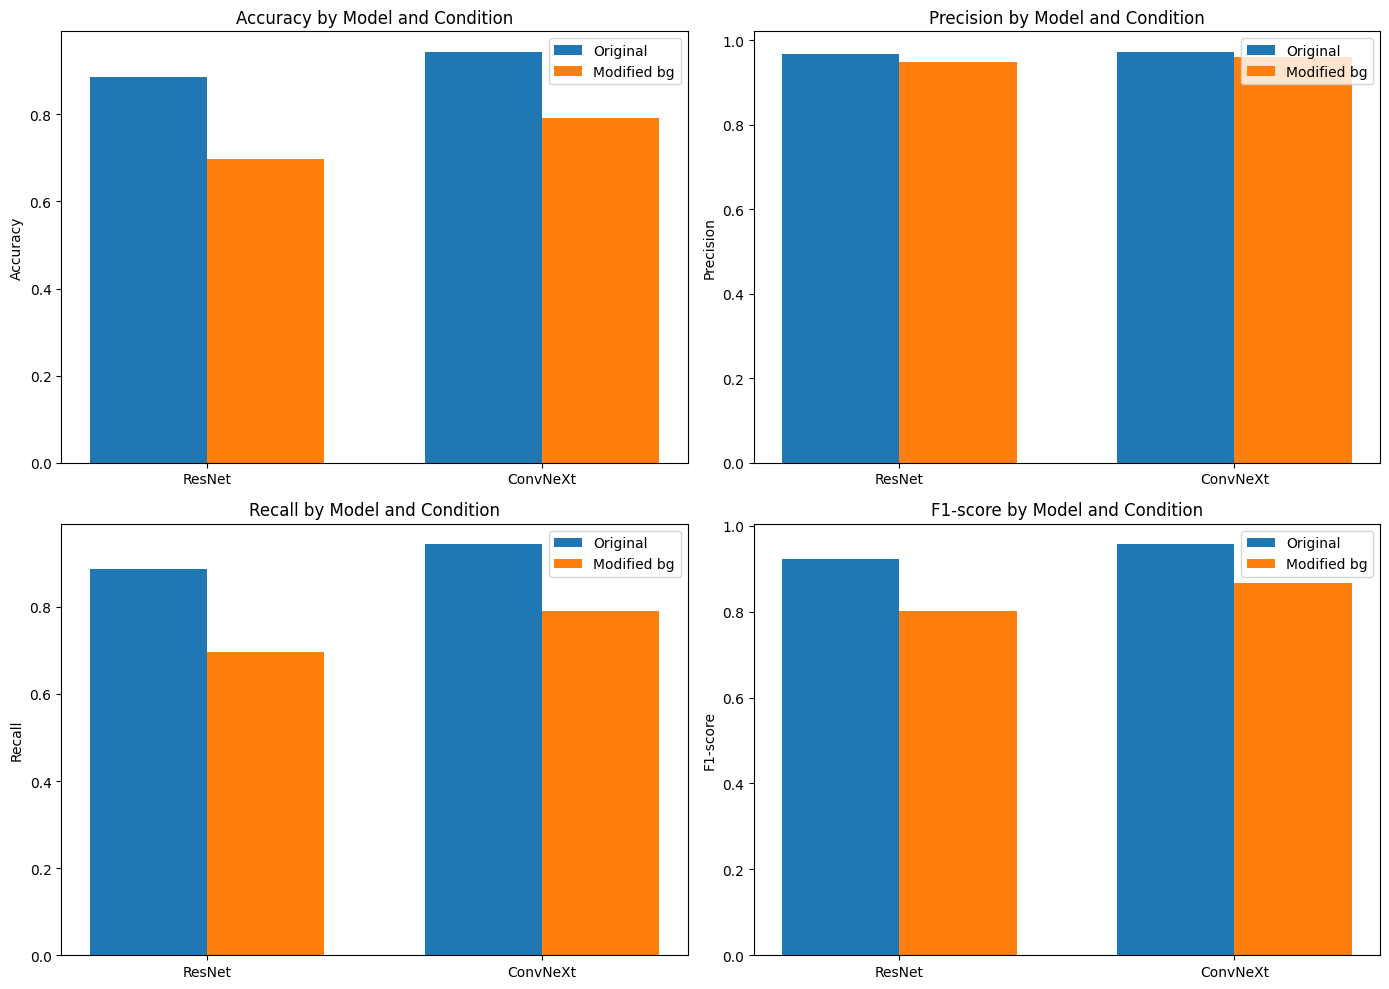

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

fig, ax = plt.subplots(2, 2, figsize=(14, 10))
x = np.arange(len(results_df['Model'].unique()))
width = 0.35

def create_bar_plot(ax, df, metric_name):
    original = df[df['Type'] == 'Original'][metric_name].values
    modified = df[df['Type'] == 'Modified'][metric_name].values

    rects1 = ax.bar(x - width/2, original, width, label='Original')
    rects2 = ax.bar(x + width/2, modified, width, label='Modified bg')

    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by Model and Condition')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Model'].unique())
    ax.legend()

for idx, metric in enumerate(metrics):
    create_bar_plot(ax[idx//2, idx%2], results_df, metric)

fig.tight_layout()
plt.show()


In [167]:
def calculate_average_scores(df):
    df['true_label'] = df['true_label'].astype(int)
    df['original_prediction'] = df['original_prediction'].astype(int)
    
    avg_original_score = df['original_score'].mean()

    correct_predictions = df[df['original_prediction'] == df['true_label']]
    avg_correct_score = correct_predictions['original_score'].mean()


    incorrect_predictions = df[df['original_prediction'] != df['true_label']]
    avg_incorrect_score = incorrect_predictions['original_score'].mean()

    return avg_original_score, avg_correct_score, avg_incorrect_score

In [168]:
def calculate_average_scores_all_modifications(df):
    score_columns = [col for col in df.columns if col.endswith('_score') and col != 'original_score']
    prediction_columns = [col for col in df.columns if col.endswith('_prediction') and col != 'original_prediction']
    
    all_scores = []
    correct_scores = []
    incorrect_scores = []

    for score_col, pred_col in zip(score_columns, prediction_columns):
        df['true_label'] = df['true_label'].astype(int)
        df[pred_col] = df[pred_col].astype(int)
        
        all_scores.extend(df[score_col])

        correct_predictions = df[df[pred_col] == df['true_label']]
        correct_scores.extend(correct_predictions[score_col])

        incorrect_predictions = df[df[pred_col] != df['true_label']]
        incorrect_scores.extend(incorrect_predictions[score_col])
    

    avg_all_score = sum(all_scores) / len(all_scores)
    avg_correct_score = sum(correct_scores) / len(correct_scores)
    avg_incorrect_score = sum(incorrect_scores) / len(incorrect_scores)

    return avg_all_score, avg_correct_score, avg_incorrect_score

      Model      Type  Average Score  Average Correct Score  \
0    ResNet  Original      85.188854              89.137424   
1    ResNet  Modified      71.694490              83.929904   
2  ConvNeXt  Original      85.188854              89.137424   
3  ConvNeXt  Modified      71.694490              83.929904   

   Average Incorrect Score  
0                54.348263  
1                43.546579  
2                54.348263  
3                43.546579  


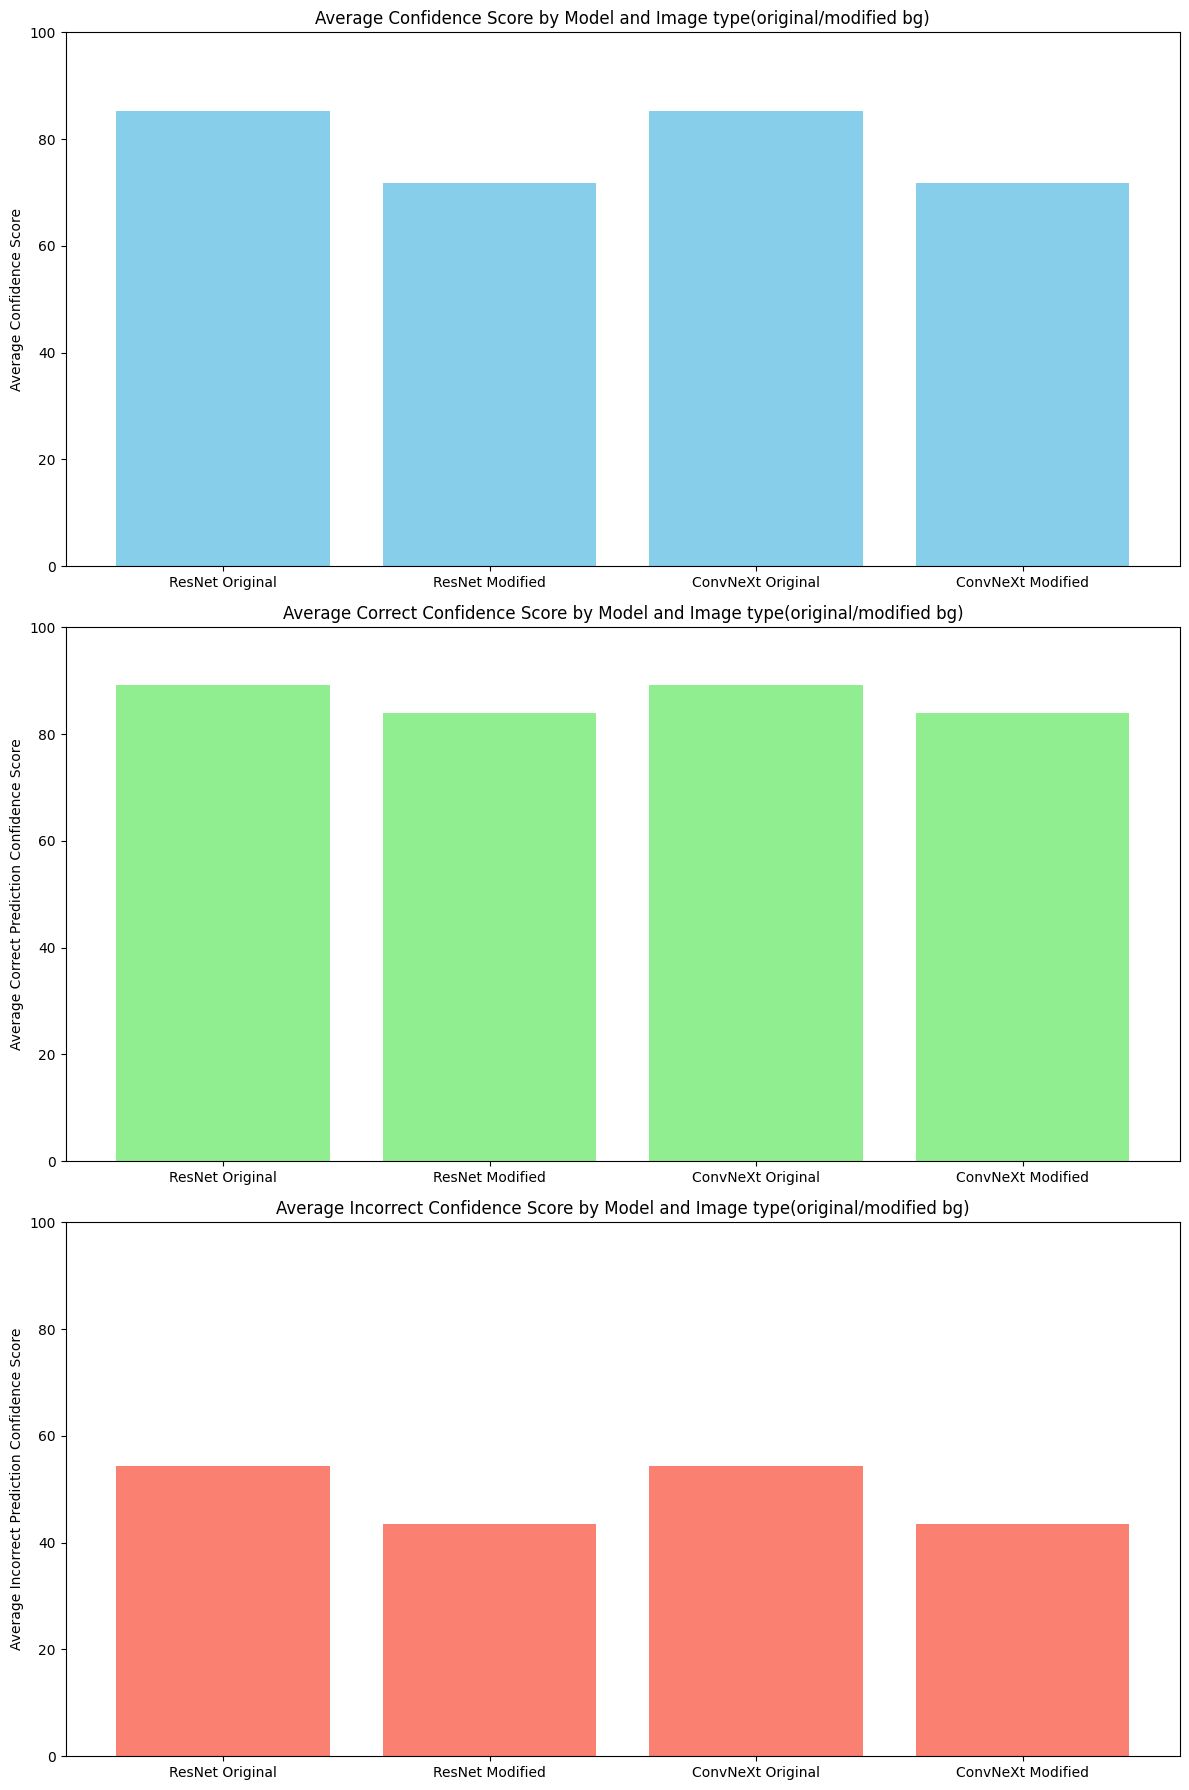

In [169]:
avg_original_resnet, avg_correct_resnet, avg_incorrect_resnet = calculate_average_scores(resnet_df)
avg_mod_resnet, avg_correct_mod_resnet, avg_incorrect_mod_resnet = calculate_average_scores_all_modifications(resnet_df)
avg_original_convnext, avg_correct_convnext, avg_incorrect_convnext = calculate_average_scores(resnet_df)
avg_mod_convnext, avg_correct_mod_convnext, avg_incorrect_mod_convnext = calculate_average_scores_all_modifications(resnet_df)

results_data = {
    'Model': ['ResNet', 'ResNet', 'ConvNeXt', 'ConvNeXt'],
    'Type': ['Original', 'Modified', 'Original', 'Modified'],
    'Average Score': [
        avg_original_resnet, avg_mod_resnet, avg_original_convnext, avg_mod_convnext
    ],
    'Average Correct Score': [
        avg_correct_resnet, avg_correct_mod_resnet, avg_correct_convnext, avg_correct_mod_convnext
    ],
    'Average Incorrect Score': [
        avg_incorrect_resnet, avg_incorrect_mod_resnet, avg_incorrect_convnext, avg_incorrect_mod_convnext
    ]
}

results_df = pd.DataFrame(results_data)
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].bar(results_df['Model'] + ' ' + results_df['Type'], results_df['Average Score'], color='skyblue')
axs[0].set_title('Average Confidence Score by Model and Image type(original/modified bg)')
axs[0].set_ylabel('Average Confidence Score')
axs[0].set_ylim(0, 100)

axs[1].bar(results_df['Model'] + ' ' + results_df['Type'], results_df['Average Correct Score'], color='lightgreen')
axs[1].set_title('Average Correct Confidence Score by Model and Image type(original/modified bg)')
axs[1].set_ylabel('Average Correct Prediction Confidence Score')
axs[1].set_ylim(0, 100)

axs[2].bar(results_df['Model'] + ' ' + results_df['Type'], results_df['Average Incorrect Score'], color='salmon')
axs[2].set_title('Average Incorrect Confidence Score by Model and Image type(original/modified bg)')
axs[2].set_ylabel('Average Incorrect Prediction Confidence Score')
axs[2].set_ylim(0, 100)

print(results_df)
plt.tight_layout()
plt.show()

In [170]:
save_df(resnet_df, resnet_results_path)
save_df(convnext_df, convnext_results_path)

In [171]:
resnet_df.head()

,object_percentage_category,true_label,true_label_description,original_score,original_prediction,desert_score,desert_prediction,low_score,low_prediction,city_score,city_prediction,sky_score,sky_prediction,jungle_score,jungle_prediction,no_score,no_prediction,high_score,high_prediction,water_score,water_prediction,snow_score,snow_prediction,indoor_score,indoor_prediction,mountain_score,mountain_prediction
0,small,348,"ram, tup",58.839279,349,80.977097,348,50.551521,349,69.934639,348,82.987450,348,72.272240,348,29.558765,240,87.865593,348,79.904648,348,67.014305,349,26.773108,453,77.038040,349
1,small,348,"ram, tup",75.892090,348,22.872158,348,69.402061,348,88.528374,348,69.020668,348,65.185081,348,34.195347,295,86.046425,348,51.148842,348,80.982758,348,16.747709,87,92.803429,348
2,small,348,"ram, tup",81.076469,348,93.878342,348,62.501762,348,58.977772,348,94.132629,348,95.790382,348,56.970715,295,87.129959,348,95.263901,348,75.683281,348,89.990028,348,93.176178,348
3,small,348,"ram, tup",53.754341,348,70.883713,349,62.867821,349,50.269855,348,60.222435,349,52.651096,348,11.731533,649,58.879681,349,50.064980,349,70.590103,349,59.058559,349,68.489357,349
4,small,348,"ram, tup",89.708168,349,87.256088,349,83.907135,349,83.456581,349,82.660828,349,65.849808,349,91.065613,349,77.554497,349,67.722954,349,88.169632,349,74.471443,349,88.701241,349


In [172]:
def define_columns(df):
    prediction_columns = [col for col in df.columns if col.endswith('_prediction')]
    confidence_columns = [col for col in df.columns if col.endswith('_score')]
    return prediction_columns, confidence_columns


In [175]:
def correlation_analysis(df, confidence_columns):
    confidence_df = df[confidence_columns]  # Exclude 'object_percentage_category'
    correlations = confidence_df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Confidence Scores')
    plt.show()

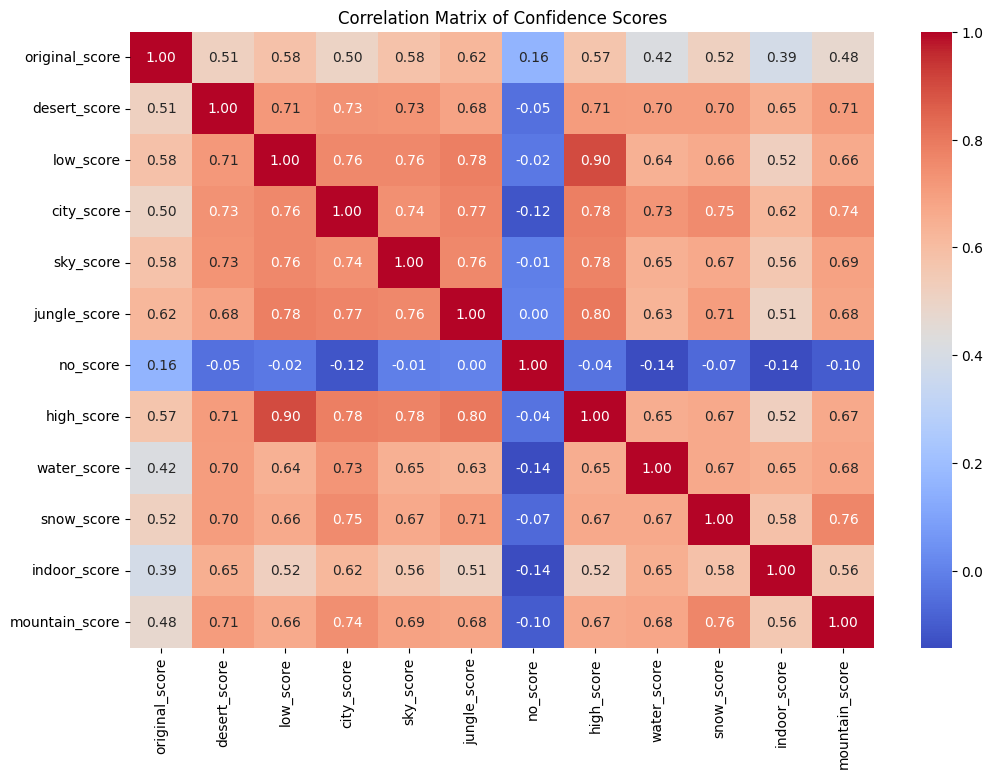

In [176]:
pred, conf = define_columns(resnet_df)
correlation_analysis(resnet_df, conf)

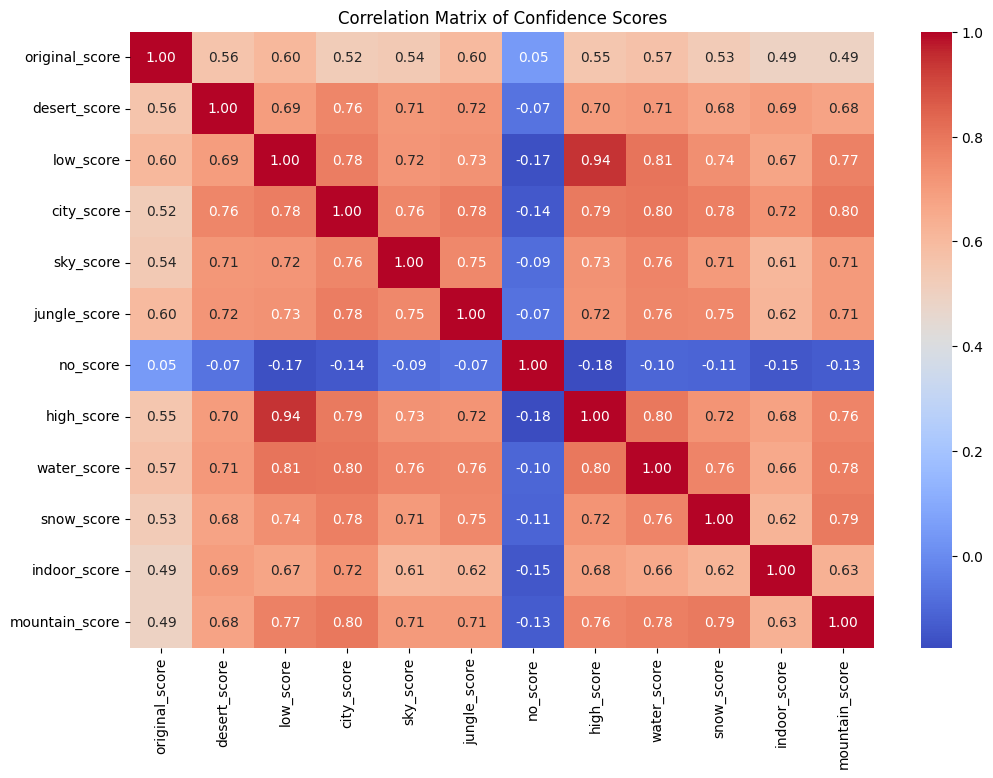

In [177]:
pred, conf = define_columns(convnext_df)
correlation_analysis(convnext_df, conf)

In [178]:
def confidence_score_distribution(df, prediction_columns, confidence_columns):
    df['true_label'] = df['true_label'].astype(int)
    for col in prediction_columns:
        df[col] = df[col].astype(int)

    def is_correct_prediction(row, prediction_col, true_label_col='true_label'):
        return row[true_label_col] == row[prediction_col]

    for pred_col in prediction_columns:
        df[pred_col + '_correct'] = df.apply(lambda row: is_correct_prediction(row, pred_col), axis=1)

    correct_confidences = []
    incorrect_confidences = []

    for score_col, pred_col in zip(confidence_columns, prediction_columns):
        correct_confidences.extend(df[df[pred_col + '_correct']][score_col].dropna().tolist())
        incorrect_confidences.extend(df[~df[pred_col + '_correct']][score_col].dropna().tolist())

    plt.figure(figsize=(12, 6))
    sns.histplot(correct_confidences, color='green', label='Correct Predictions', kde=True, stat="density")
    sns.histplot(incorrect_confidences, color='red', label='Incorrect Predictions', kde=True, stat="density")
    plt.title('Distribution of Confidence Scores for Correct vs Incorrect Predictions')
    plt.xlabel('Confidence Score')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [179]:
resnet_df.head()

,object_percentage_category,true_label,true_label_description,original_score,original_prediction,desert_score,desert_prediction,low_score,low_prediction,city_score,city_prediction,sky_score,sky_prediction,jungle_score,jungle_prediction,no_score,no_prediction,high_score,high_prediction,water_score,water_prediction,snow_score,snow_prediction,indoor_score,indoor_prediction,mountain_score,mountain_prediction
0,small,348,"ram, tup",58.839279,349,80.977097,348,50.551521,349,69.934639,348,82.987450,348,72.272240,348,29.558765,240,87.865593,348,79.904648,348,67.014305,349,26.773108,453,77.038040,349
1,small,348,"ram, tup",75.892090,348,22.872158,348,69.402061,348,88.528374,348,69.020668,348,65.185081,348,34.195347,295,86.046425,348,51.148842,348,80.982758,348,16.747709,87,92.803429,348
2,small,348,"ram, tup",81.076469,348,93.878342,348,62.501762,348,58.977772,348,94.132629,348,95.790382,348,56.970715,295,87.129959,348,95.263901,348,75.683281,348,89.990028,348,93.176178,348
3,small,348,"ram, tup",53.754341,348,70.883713,349,62.867821,349,50.269855,348,60.222435,349,52.651096,348,11.731533,649,58.879681,349,50.064980,349,70.590103,349,59.058559,349,68.489357,349
4,small,348,"ram, tup",89.708168,349,87.256088,349,83.907135,349,83.456581,349,82.660828,349,65.849808,349,91.065613,349,77.554497,349,67.722954,349,88.169632,349,74.471443,349,88.701241,349


In [180]:
convnext_df.head()

,object_percentage_category,true_label,true_label_description,original_score,original_prediction,desert_score,desert_prediction,low_score,low_prediction,city_score,city_prediction,sky_score,sky_prediction,jungle_score,jungle_prediction,no_score,no_prediction,high_score,high_prediction,water_score,water_prediction,snow_score,snow_prediction,indoor_score,indoor_prediction,mountain_score,mountain_prediction
0,small,348,"ram, tup",46.373386,349,39.178246,349,35.915047,349,36.261684,349,32.841434,348,34.654091,349,32.191479,348,35.655186,349,33.616207,349,52.296246,349,34.621975,349,49.499184,349
1,small,348,"ram, tup",78.177628,348,78.905365,348,81.804100,348,85.499680,348,77.875259,348,84.753433,348,30.929214,825,80.494812,348,81.612816,348,81.916199,348,81.708229,348,85.559204,348
2,small,348,"ram, tup",79.154984,348,75.236961,348,77.332947,348,73.829636,348,77.585464,348,79.860634,348,52.488834,8,73.709946,348,76.116119,348,58.095898,348,73.713272,348,64.670166,348
3,small,348,"ram, tup",40.402241,348,41.739841,349,37.637833,348,39.782448,349,36.871704,348,33.927750,348,30.554974,295,37.928951,348,39.006672,349,43.786774,349,41.510838,349,39.187191,349
4,small,348,"ram, tup",49.981297,349,44.770977,349,32.670235,348,42.254787,349,34.506985,349,33.637314,349,64.156876,349,33.935677,349,35.364922,349,44.977673,349,47.262661,349,44.087524,349


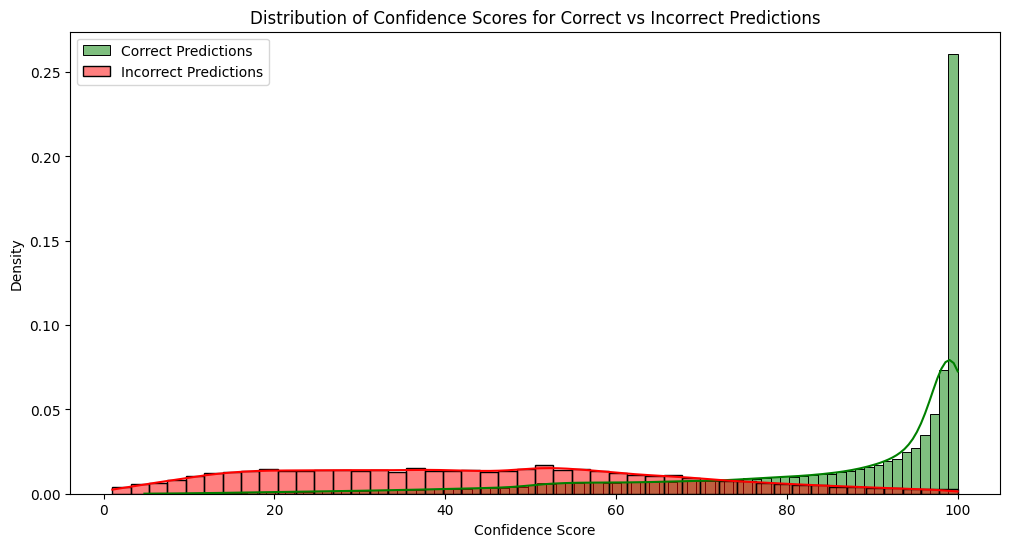

In [181]:
prediction_columns, confidence_columns = define_columns(resnet_df)

confidence_score_distribution(resnet_df, prediction_columns, confidence_columns)

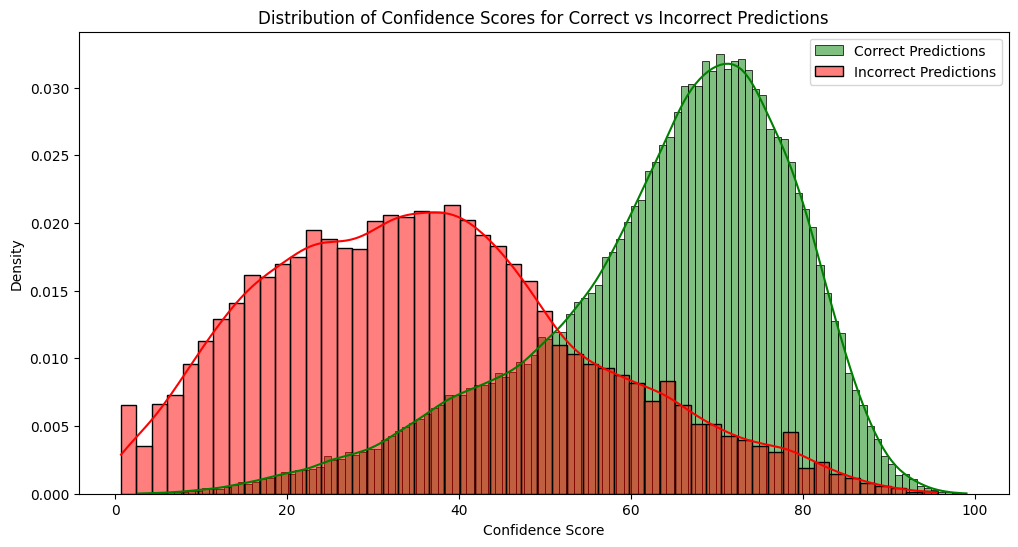

In [182]:
prediction_columns, confidence_columns = define_columns(convnext_df)

confidence_score_distribution(convnext_df, prediction_columns, confidence_columns)

In [186]:
resnet_results_path = os.path.join('results', 'resnet_df.pkl')
convnext_results_path = os.path.join('results', 'convnext_df.pkl')
save_df(resnet_df, resnet_results_path)
save_df(convnext_df, convnext_results_path)

In [187]:
resnet_df = load_df(resnet_results_path)
convnext_df = load_df(convnext_results_path)

In [188]:
resnet_df.head()

,object_percentage_category,true_label,true_label_description,original_score,original_prediction,desert_score,desert_prediction,low_score,low_prediction,city_score,city_prediction,sky_score,sky_prediction,jungle_score,jungle_prediction,no_score,no_prediction,high_score,high_prediction,water_score,water_prediction,snow_score,snow_prediction,indoor_score,indoor_prediction,mountain_score,mountain_prediction,original_prediction_correct,desert_prediction_correct,low_prediction_correct,city_prediction_correct,sky_prediction_correct,jungle_prediction_correct,no_prediction_correct,high_prediction_correct,water_prediction_correct,snow_prediction_correct,indoor_prediction_correct,mountain_prediction_correct
0,small,348,"ram, tup",58.839279,349,80.977097,348,50.551521,349,69.934639,348,82.987450,348,72.272240,348,29.558765,240,87.865593,348,79.904648,348,67.014305,349,26.773108,453,77.038040,349,False,True,False,True,True,True,False,True,True,False,False,False
1,small,348,"ram, tup",75.892090,348,22.872158,348,69.402061,348,88.528374,348,69.020668,348,65.185081,348,34.195347,295,86.046425,348,51.148842,348,80.982758,348,16.747709,87,92.803429,348,True,True,True,True,True,True,False,True,True,True,False,True
2,small,348,"ram, tup",81.076469,348,93.878342,348,62.501762,348,58.977772,348,94.132629,348,95.790382,348,56.970715,295,87.129959,348,95.263901,348,75.683281,348,89.990028,348,93.176178,348,True,True,True,True,True,True,False,True,True,True,True,True
3,small,348,"ram, tup",53.754341,348,70.883713,349,62.867821,349,50.269855,348,60.222435,349,52.651096,348,11.731533,649,58.879681,349,50.064980,349,70.590103,349,59.058559,349,68.489357,349,True,False,False,True,False,True,False,False,False,False,False,False
4,small,348,"ram, tup",89.708168,349,87.256088,349,83.907135,349,83.456581,349,82.660828,349,65.849808,349,91.065613,349,77.554497,349,67.722954,349,88.169632,349,74.471443,349,88.701241,349,False,False,False,False,False,False,False,False,False,False,False,False


   Class Background  Accuracy  Precision    Recall  F1-Score
0    348   original     0.781   0.052632  0.041105  0.046160
1    238   original     0.746   0.021739  0.016217  0.018577
2     94   original     0.963   0.041667  0.040125  0.040881
3    285   original     0.782   0.027027  0.021135  0.023721
4    349   original     0.857   0.071429  0.061214  0.065928
..   ...        ...       ...        ...       ...       ...
5    229   mountain     0.715   0.016667  0.011917  0.013897
6    283   mountain     0.794   0.020833  0.016542  0.018441
7     13   mountain     0.797   0.037037  0.029519  0.032853
8    235   mountain     0.666   0.014493  0.009652  0.011587
9     15   mountain     0.879   0.043478  0.038217  0.040678

[120 rows x 6 columns]


/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

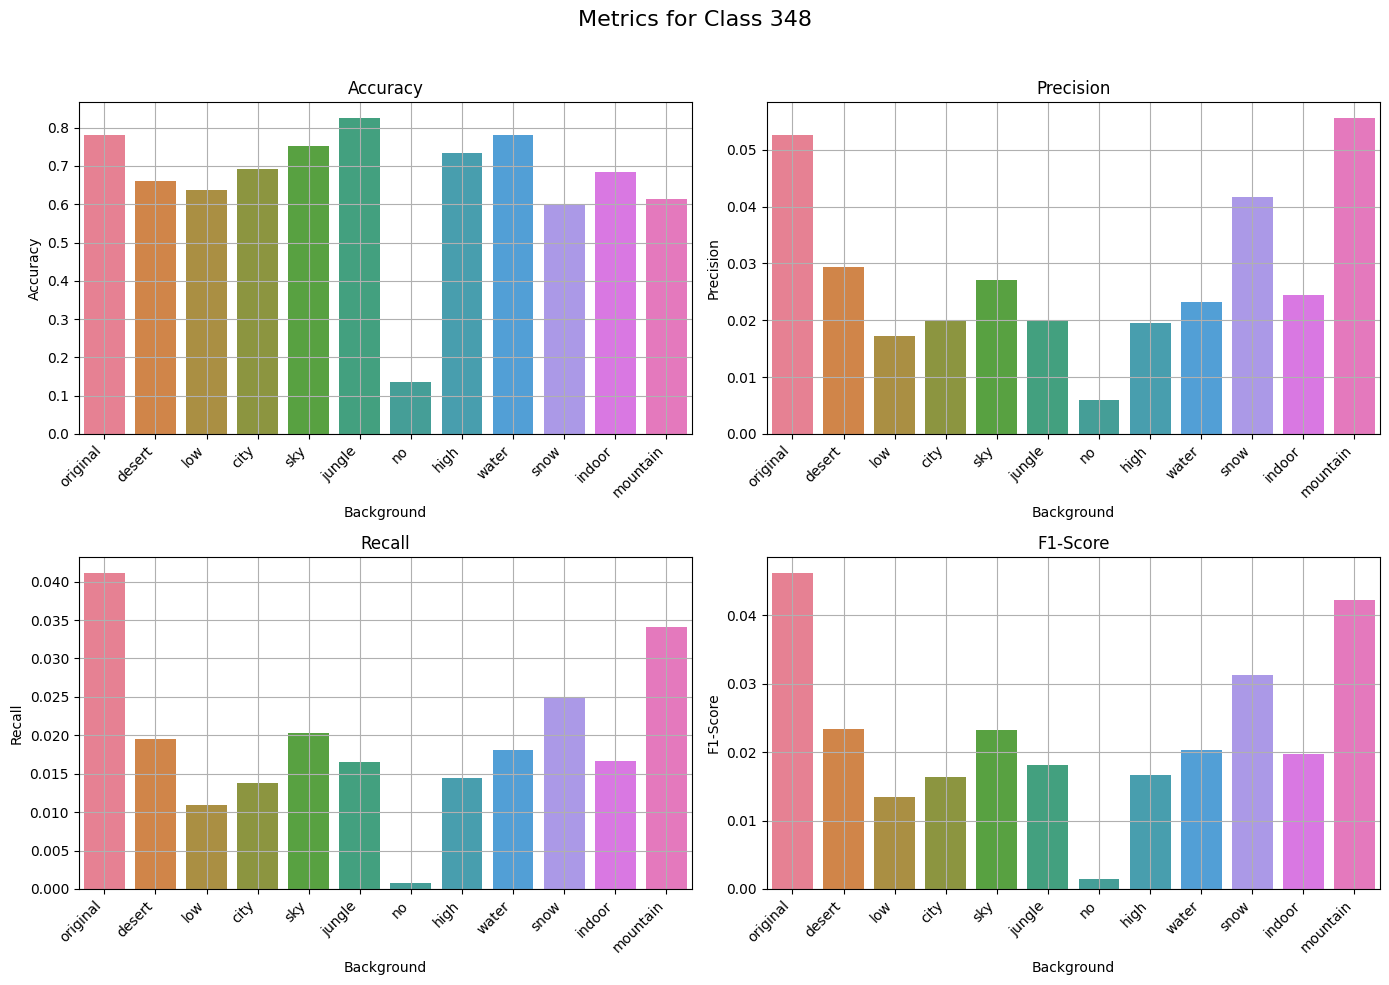

/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

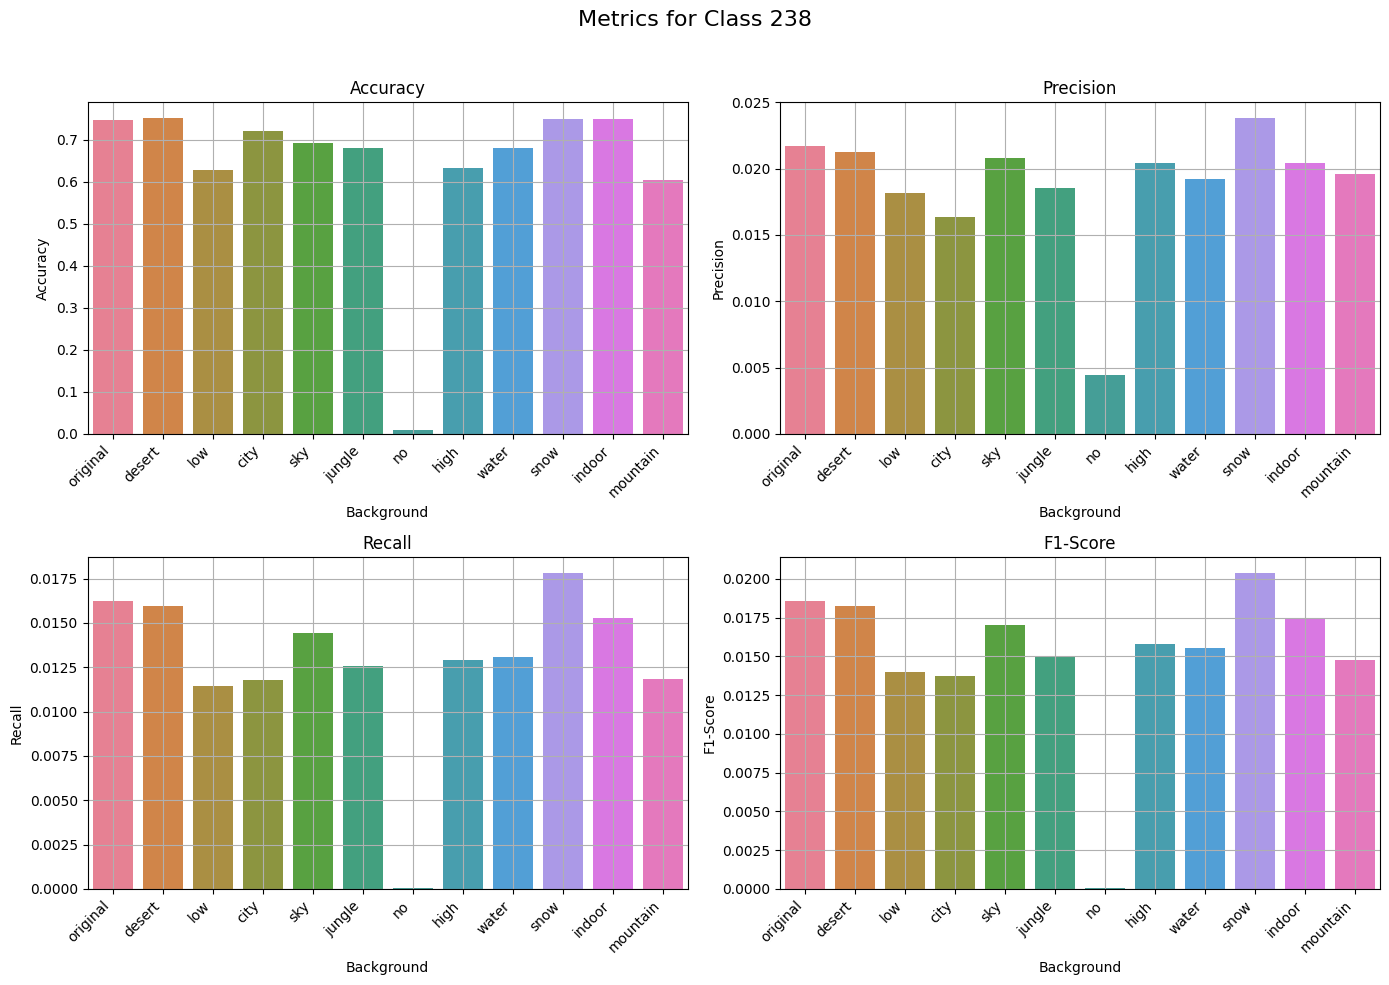

/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

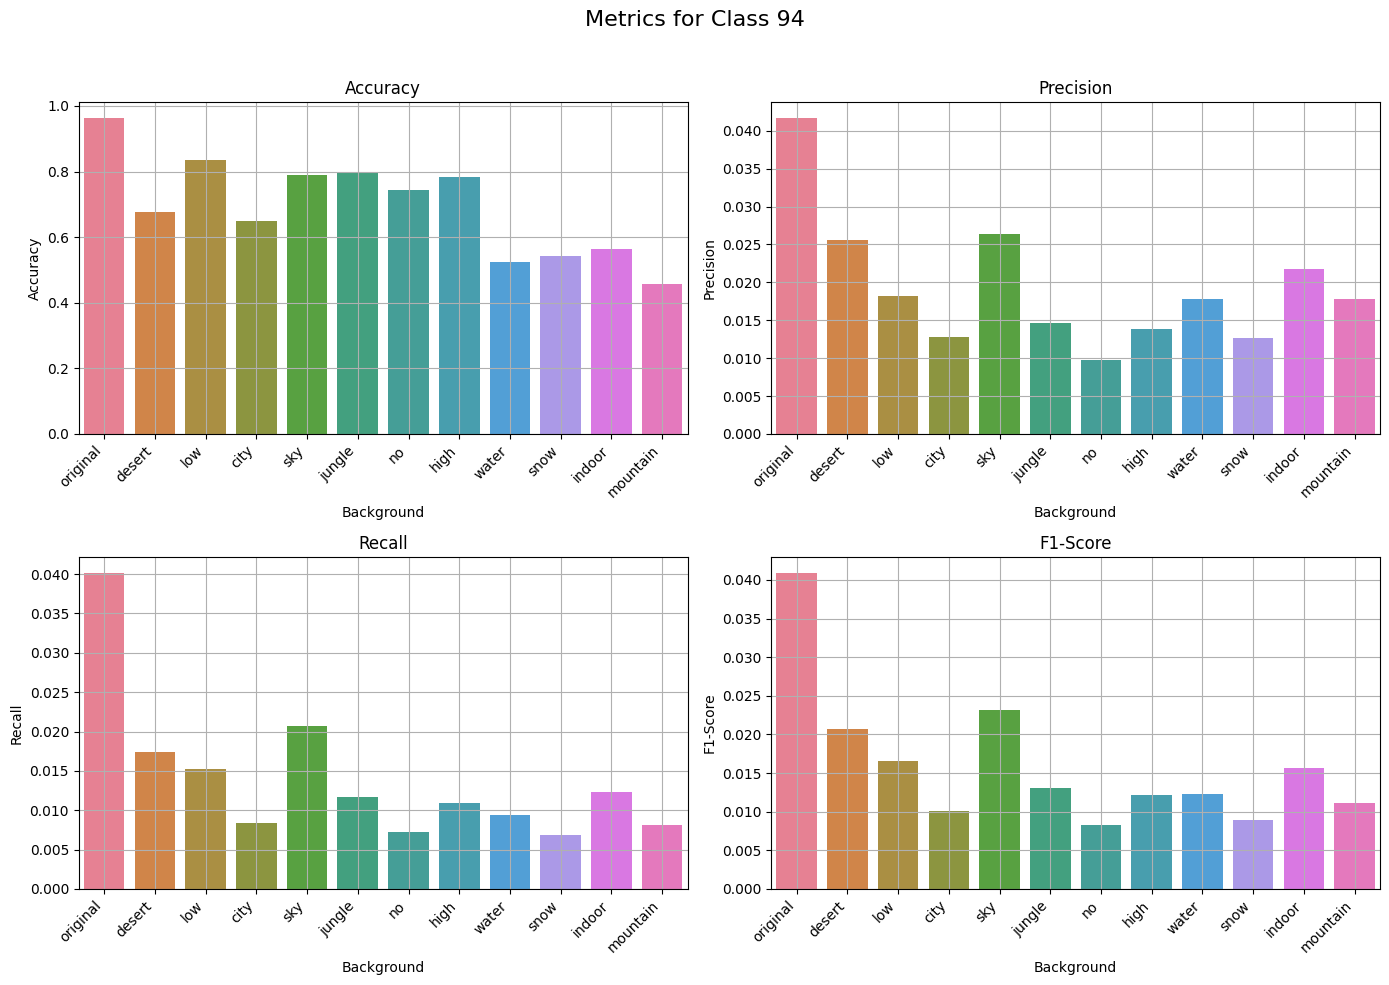

/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

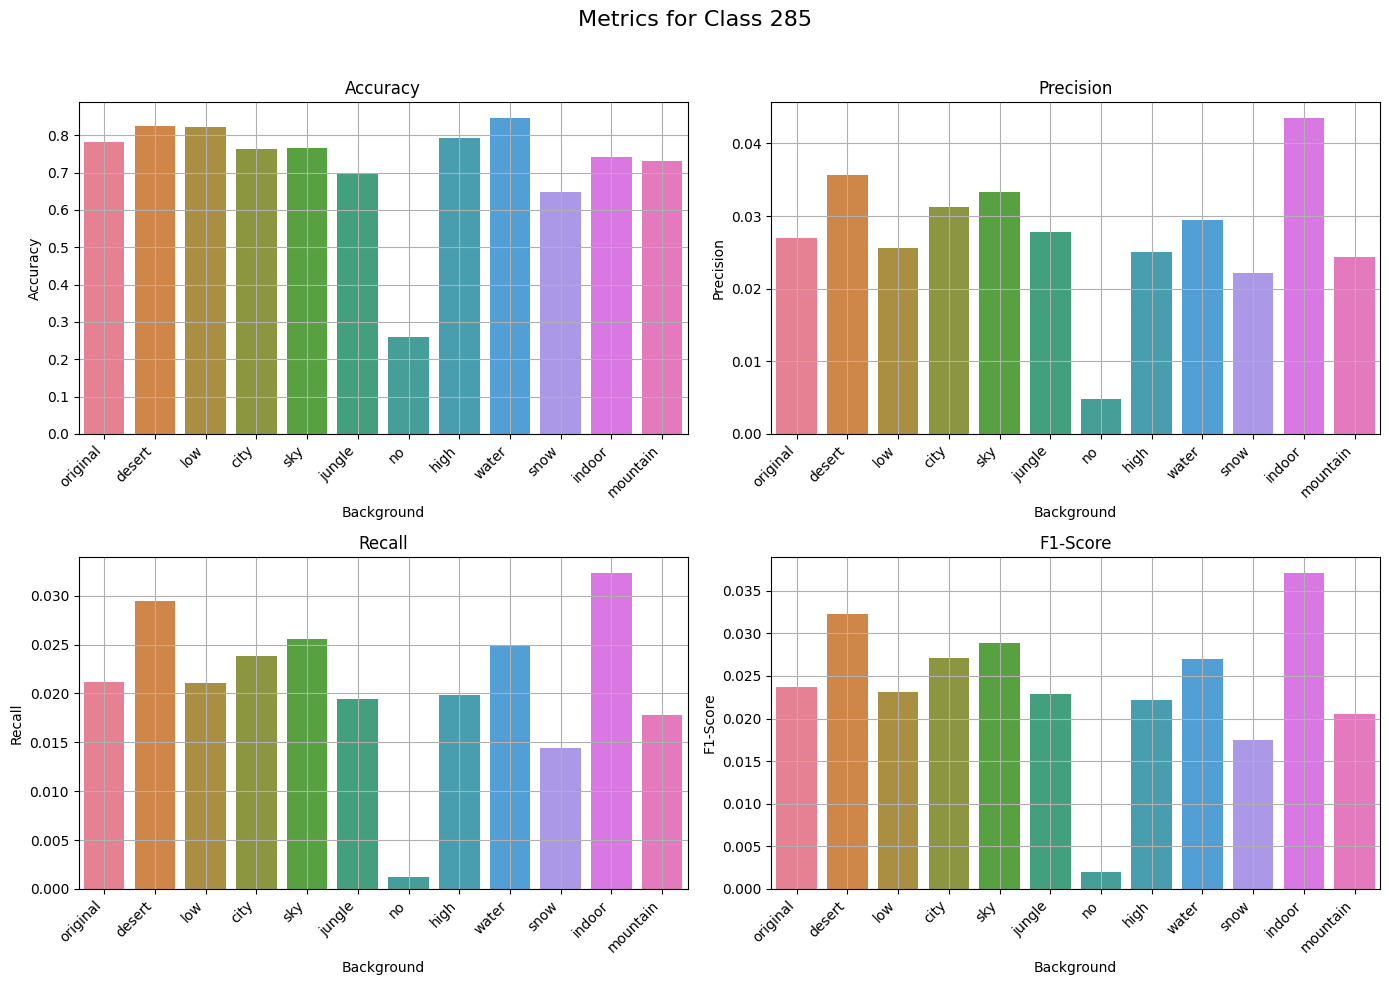

/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

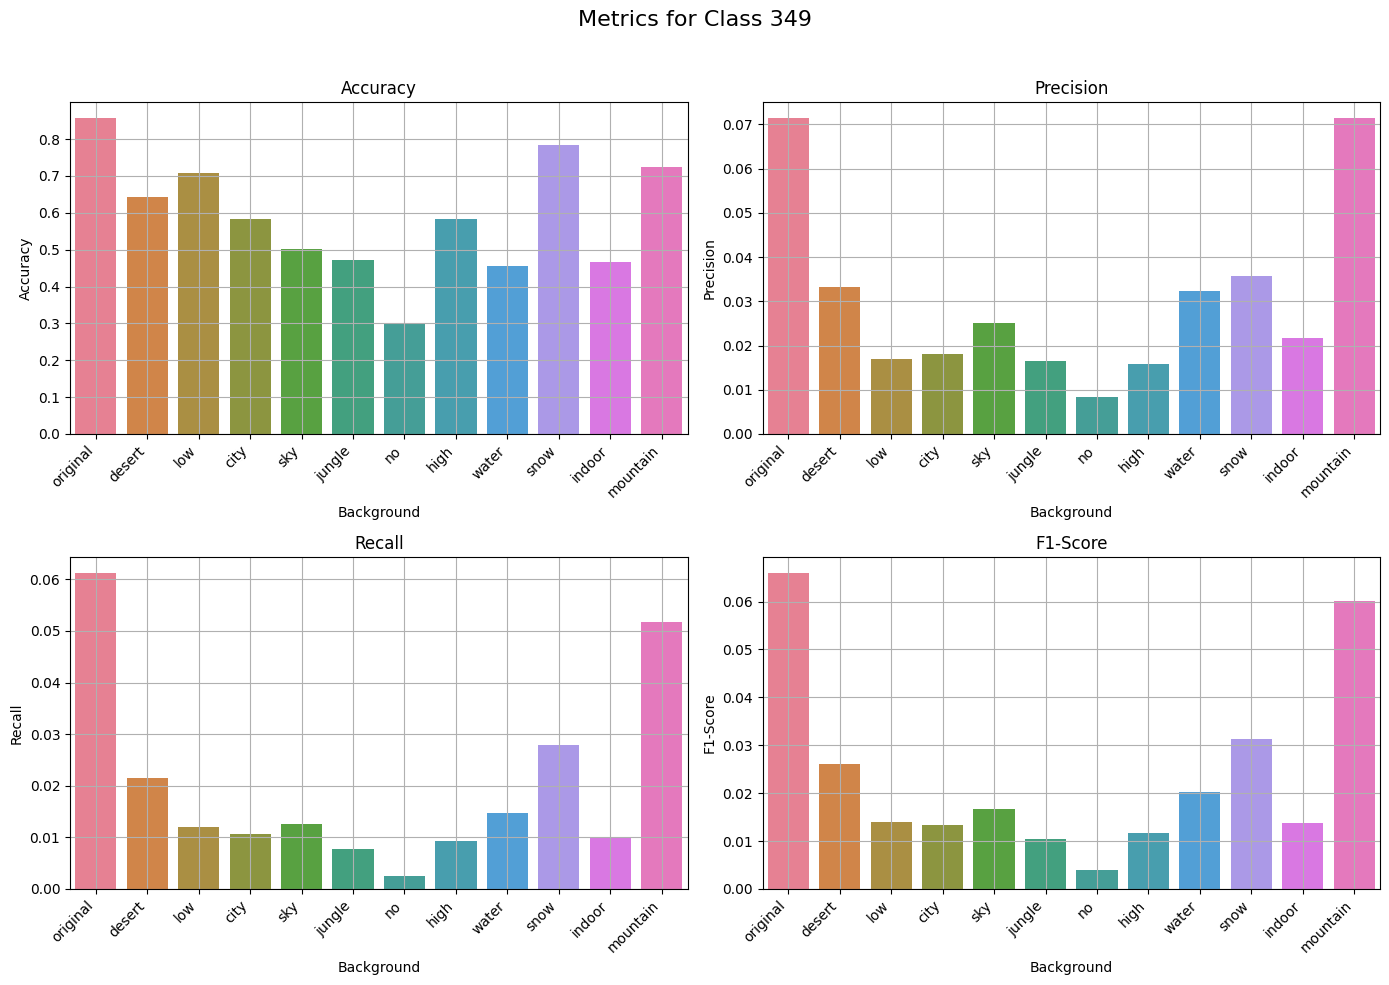

/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

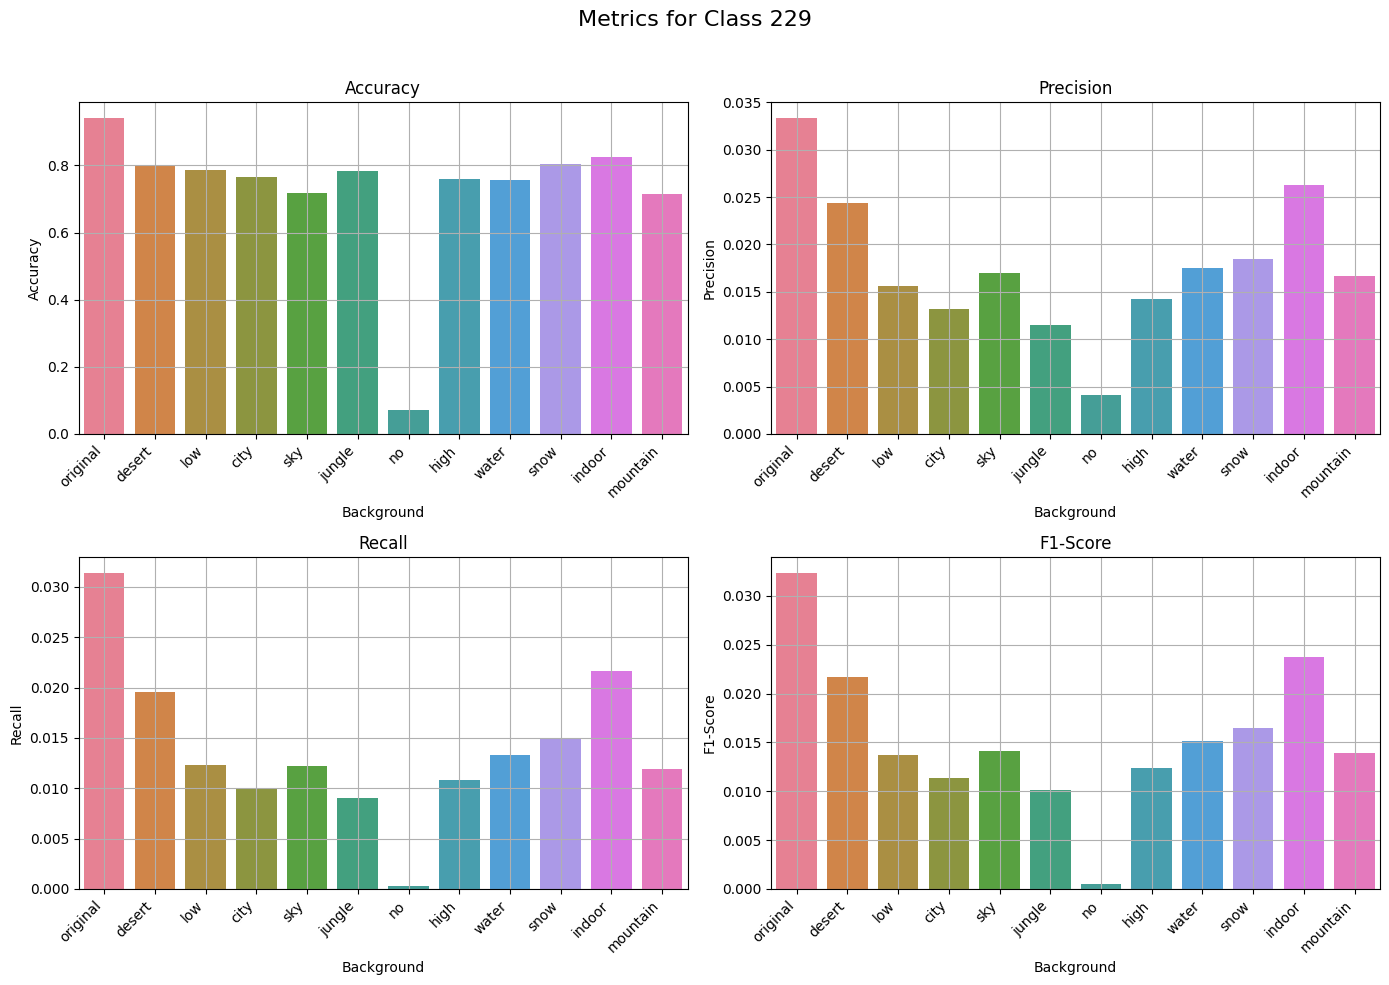

/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

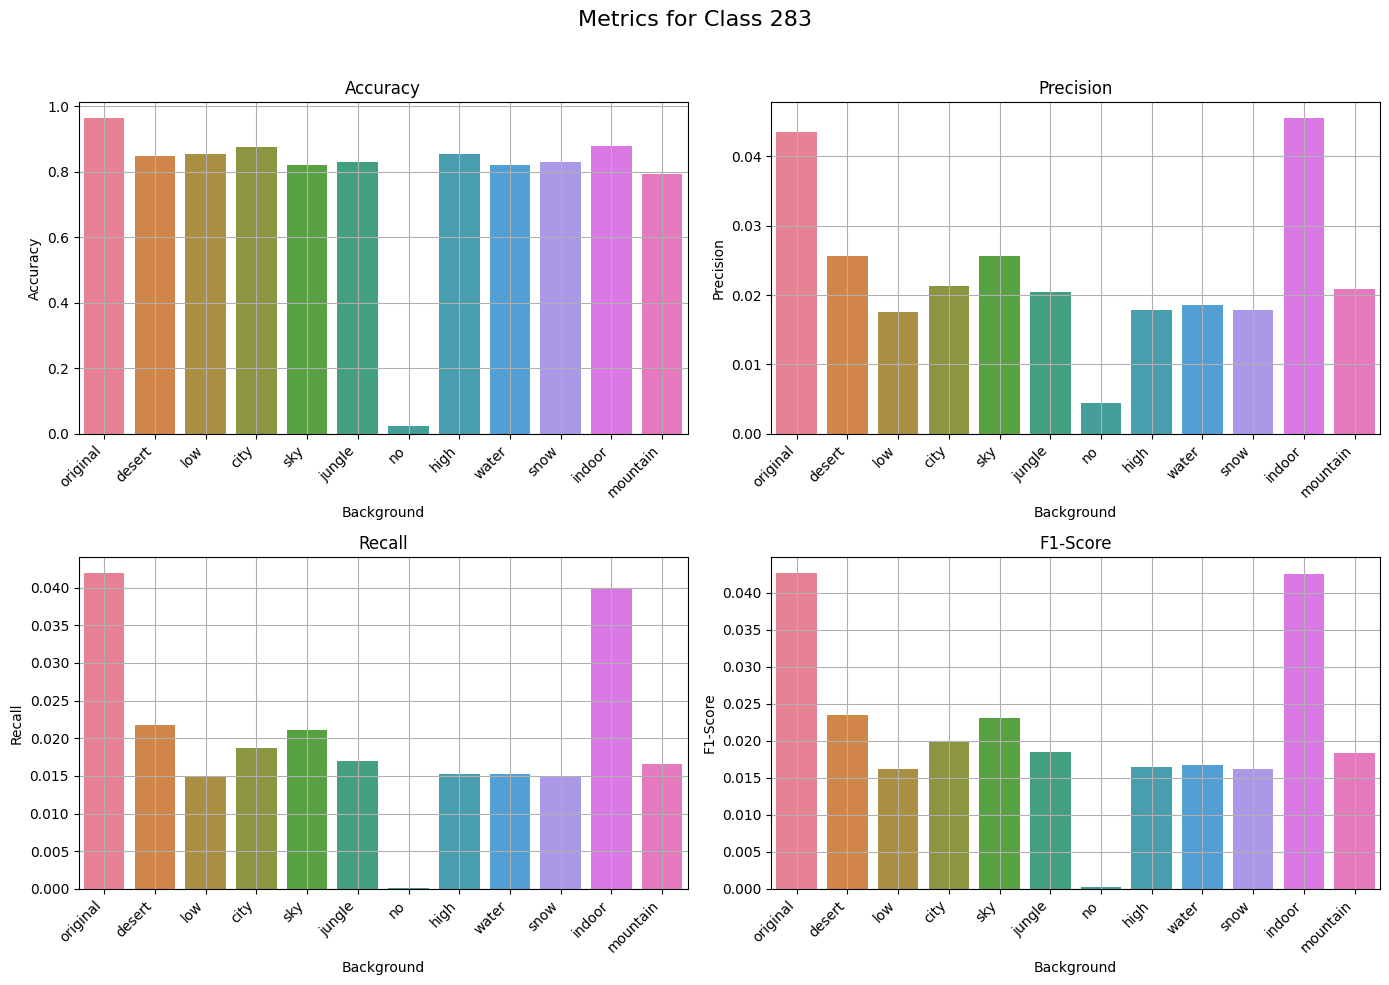

/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

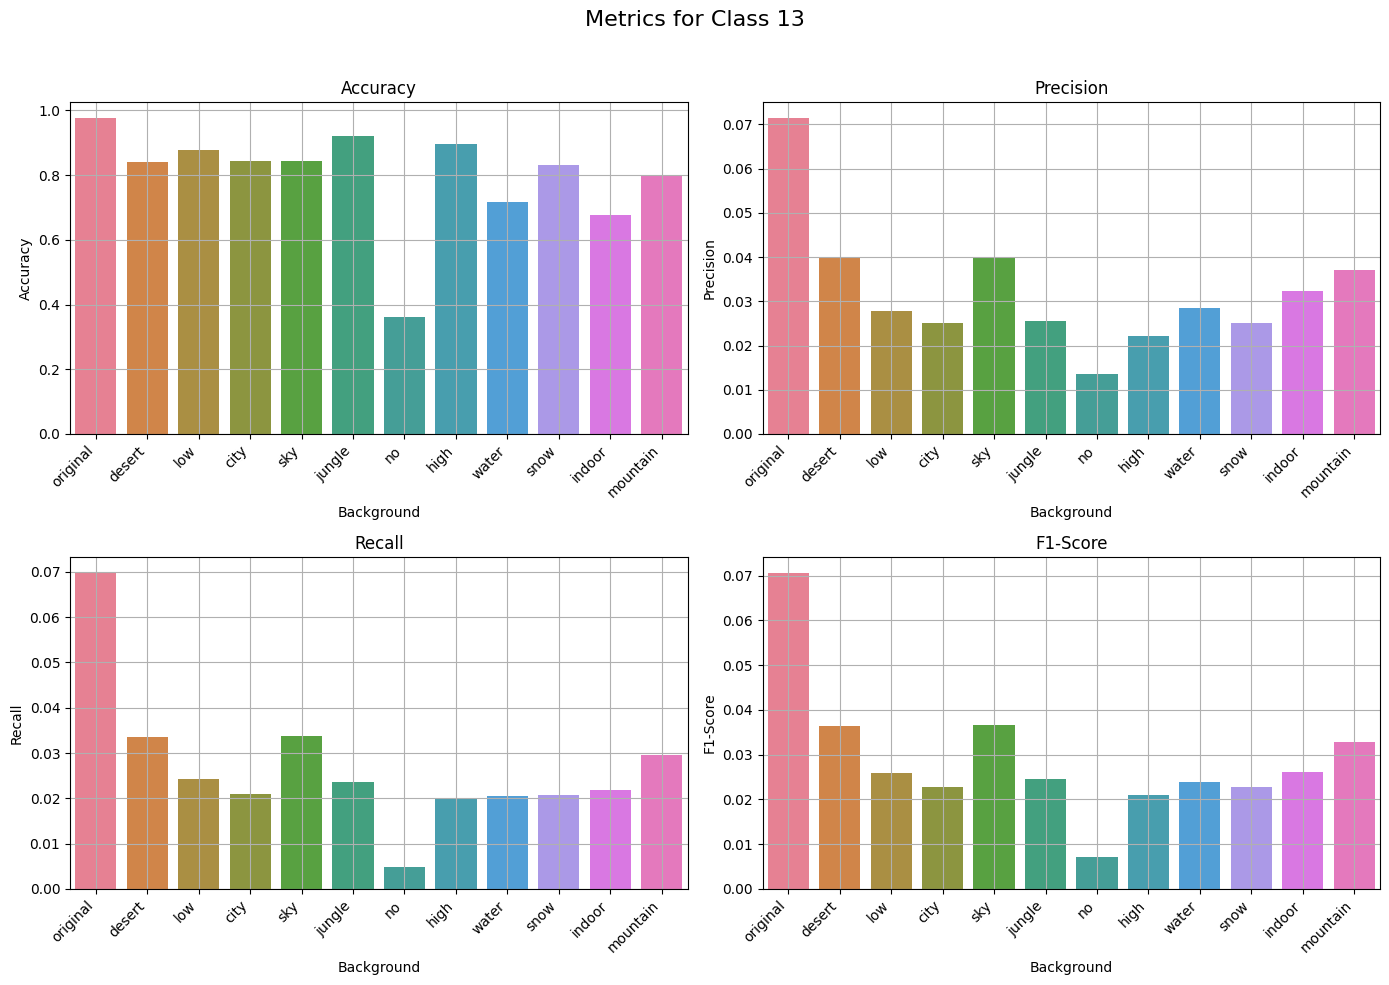

/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

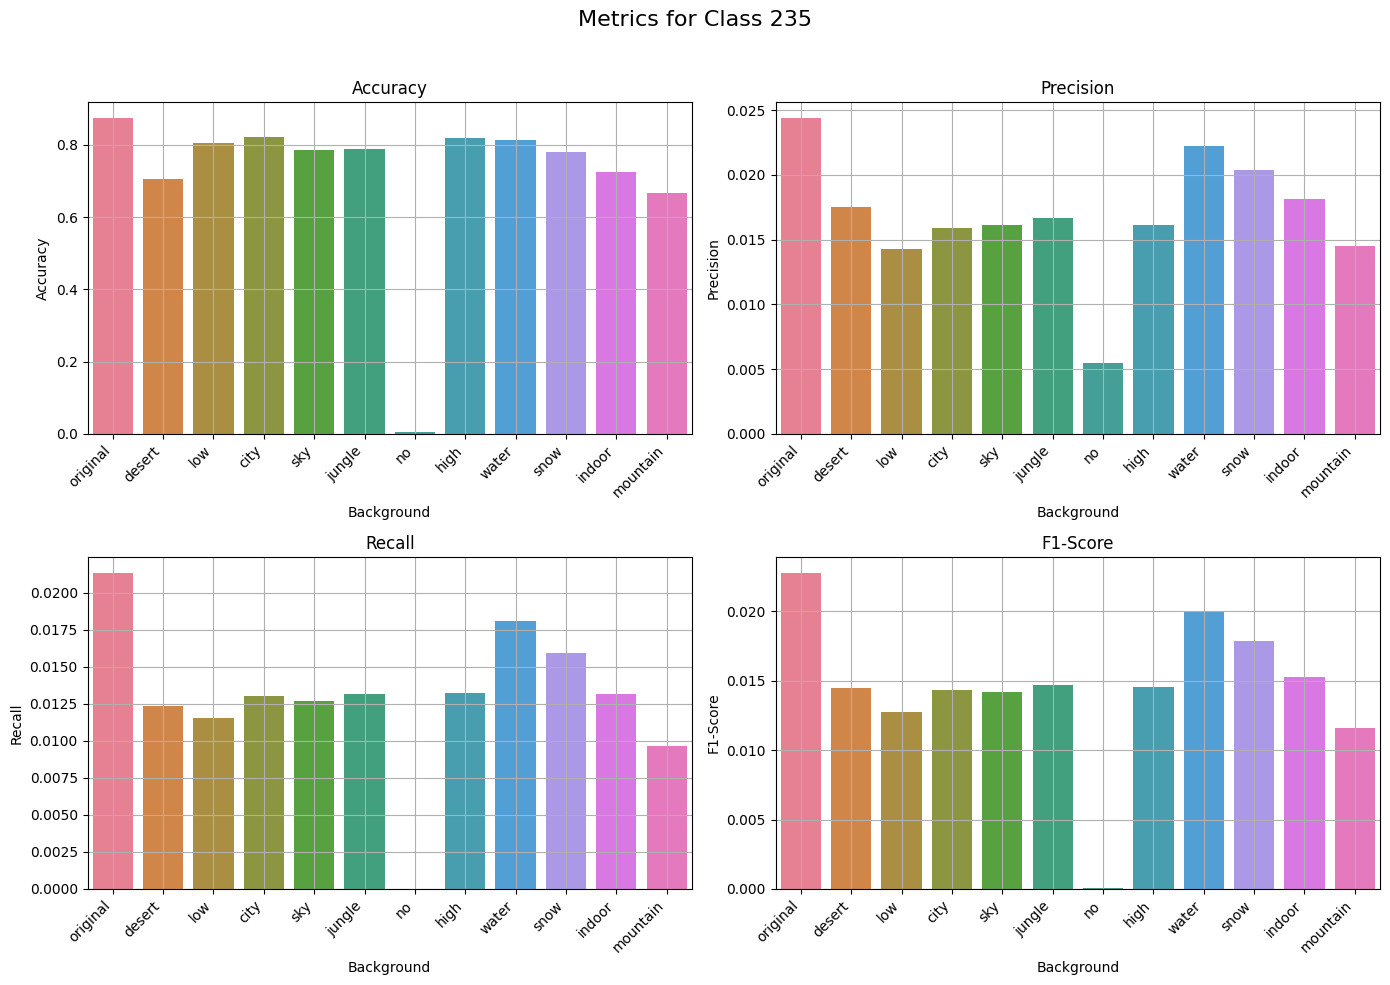

/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
/tmp/ipykernel_2717/1442961857.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
/tmp/ipykernel_2717/1442961857.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

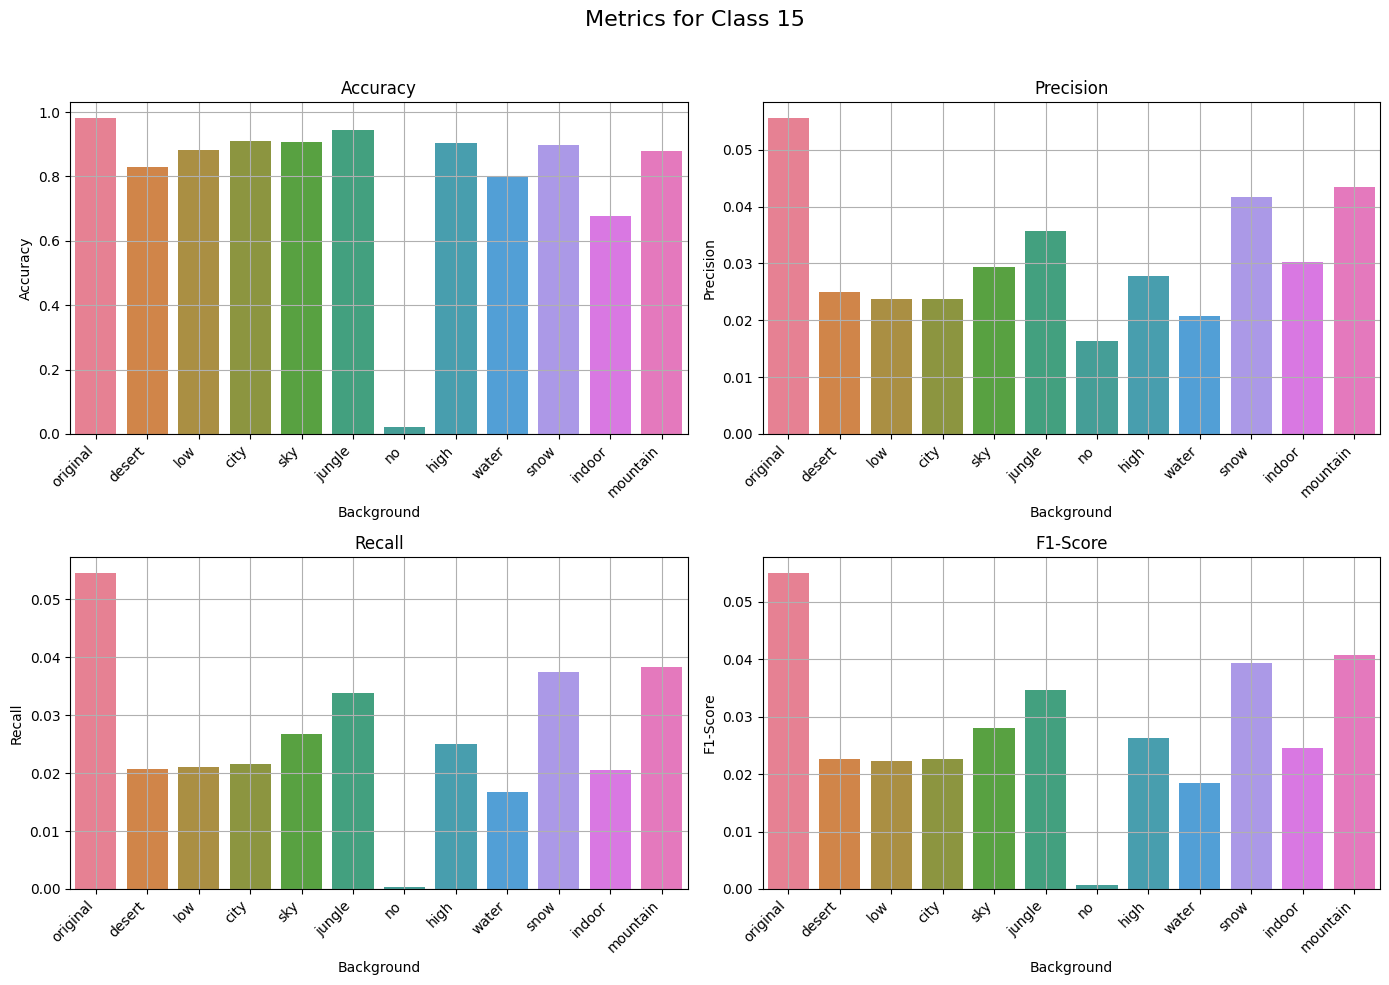

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(df, background):
    metrics = []
    unique_labels = df['true_label'].unique()
    
    for label in unique_labels:
        true_labels = df[df['true_label'] == label]['true_label']
        pred_labels = df[df['true_label'] == label][f'{background}_prediction']
        
        accuracy = accuracy_score(true_labels, pred_labels)
        precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
        recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
        f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
        
        metrics.append({
            'Class': label,
            'Background': background,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    
    return pd.DataFrame(metrics)

backgrounds = ['original', 'desert', 'low', 'city', 'sky', 'jungle', 'no', 'high', 'water', 'snow', 'indoor', 'mountain']

metrics_df_list = [calculate_metrics(resnet_df, bg) for bg in backgrounds]
metrics_df = pd.concat(metrics_df_list)

metrics_df['Class'] = metrics_df['Class'].astype('category')

print(metrics_df)



def plot_metrics_for_class(df, class_label, metrics):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Metrics for Class {class_label}', fontsize=16)
    
    palette = sns.color_palette("husl", len(df['Background'].unique()))
    for ax, metric in zip(axes.flatten(), metrics):
        subset = df[df['Class'] == class_label]
        sns.barplot(x='Background', y=metric, data=subset, ax=ax, palette=palette)
        ax.set_title(metric)
        ax.set_xlabel('Background')
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.set_xticklabels(subset['Background'], rotation=45, ha='right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for class_label in metrics_df['Class'].unique():
    plot_metrics_for_class(metrics_df, class_label, metrics)



In [183]:
resnet_df.head()

,object_percentage_category,true_label,true_label_description,original_score,original_prediction,desert_score,desert_prediction,low_score,low_prediction,city_score,city_prediction,sky_score,sky_prediction,jungle_score,jungle_prediction,no_score,no_prediction,high_score,high_prediction,water_score,water_prediction,snow_score,snow_prediction,indoor_score,indoor_prediction,mountain_score,mountain_prediction,original_prediction_correct,desert_prediction_correct,low_prediction_correct,city_prediction_correct,sky_prediction_correct,jungle_prediction_correct,no_prediction_correct,high_prediction_correct,water_prediction_correct,snow_prediction_correct,indoor_prediction_correct,mountain_prediction_correct
0,small,348,"ram, tup",58.839279,349,80.977097,348,50.551521,349,69.934639,348,82.987450,348,72.272240,348,29.558765,240,87.865593,348,79.904648,348,67.014305,349,26.773108,453,77.038040,349,False,True,False,True,True,True,False,True,True,False,False,False
1,small,348,"ram, tup",75.892090,348,22.872158,348,69.402061,348,88.528374,348,69.020668,348,65.185081,348,34.195347,295,86.046425,348,51.148842,348,80.982758,348,16.747709,87,92.803429,348,True,True,True,True,True,True,False,True,True,True,False,True
2,small,348,"ram, tup",81.076469,348,93.878342,348,62.501762,348,58.977772,348,94.132629,348,95.790382,348,56.970715,295,87.129959,348,95.263901,348,75.683281,348,89.990028,348,93.176178,348,True,True,True,True,True,True,False,True,True,True,True,True
3,small,348,"ram, tup",53.754341,348,70.883713,349,62.867821,349,50.269855,348,60.222435,349,52.651096,348,11.731533,649,58.879681,349,50.064980,349,70.590103,349,59.058559,349,68.489357,349,True,False,False,True,False,True,False,False,False,False,False,False
4,small,348,"ram, tup",89.708168,349,87.256088,349,83.907135,349,83.456581,349,82.660828,349,65.849808,349,91.065613,349,77.554497,349,67.722954,349,88.169632,349,74.471443,349,88.701241,349,False,False,False,False,False,False,False,False,False,False,False,False


In [1]:
import tensorflow as tf

# Check if GPU is available
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print(f"GPU is available: {gpu_available}")
else:
    print("GPU is not available")

ModuleNotFoundError: No module named 'tensorflow'